In [1]:
from CartPole import *
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model

# IIA project SF3: Machine Learning

Easter 2022<br>
Project Leader: Gabor Csanyi (gc121)


## Important dates

Project start: __Friday May 13 2022 12:00am GMT+1 (UK summer time)__ 

Interim report deadline: __Friday 20 May 2022, 4pm__ (electronic submission via Moodle)
<br>
(Interim report should contain report on tasks up to and including the linear modelling of the dynamics)

Final project report deadline: __Friday 10 June 2022,  4pm__ (electronic submission via Moodle)


## Project notes

- You should spend about 20 hours a week on the project, basically half of your time.
- Project is to be carried out here on Deepnote or on your own computer. You can download this notebook and use it with a normal Jupyter server, or duplicate it here in your Deepnote account. If you do the latter, you can share and show your work easily. The computational resources on Deepnote are limited, so you may find it more convenient to run the programs on your own computer in the later parts of the project. When you need to ask a question about a specific piece of code, you can still use the Deepnote system to share a notebook. 
- Make your own schedule. Help is available from the project leader during scheduled sessions: 10:00am - 11:00am (GMT+1) every weekday on in LR12. None of the subsequent sessions are compulsory, but you are strongly encouraged to seek verbal feedback after your interim report - there will be a special session for this on Monday and Tuesday, May 23-24. 
- Project carries 80 marks overall:
  - 20 marks for interim report
  - 60 marks for final report 
- Project report
  - Should be clearly broken down by _Tasks_ (see below), any notes you wish to make in how you structured and carried out the tasks, and most importantly your __results__ in the form of completely labelled graphs, and __accompanying conclusions__ you draw from your results. 
  - Should be about than 14-18 pages (Interim report about 4-6 pages) when converted to a PDF (excluding appendices such as attached code, but _including_ figures). The final report can be an extension of the interim report, but make sure you take into account the feedback you receive for your interim report.  
  - When deciding what to include in your report, how to organise it and what to emphasize, please prioritise communicating understanding over formalities - I would like give you marks for doing the right thing and showing that you did it and understand it. If I have to wade through pages of undigested data and graphs shown just because it was there, I will feel less generous. The length requirements are only guidelines. 
  - __All code__ that you used during to project must be attached as an appendix to your reports. If you modified the `CartPole.py` file, include it. 
  - A jupyter or Deepnote notebook are acceptable as a report, as long as it is "clean" (its main section includes text and figures) and reads like a report, and can be converted to a PDF for the moodle upload. 
  - Incude [cover sheets](http://teaching.eng.cam.ac.uk/node/4171) provided by the Teaching Office

## Approximate Schedule

- Week 1: Software tools, simulation of cart-pole system, linear modelling of dynamics
  - Interim report (up to linear modelling)
- Week 2: Nonlinear modelling of dynamics, linear control
- Week 3: Sensitivity analysis
- Week 4: Nonlinear control
  - Final report

<IMG src="~/work/cartpole.png" width=500>

## Week 1

### Dynamical simulation

Consider the inverted pendulum system ("cartpole") drawn above, familiar from the coursework of 3F2, with a freely moving cart and freely rotating pendulum attached to the cart, moving under the action of an external action force and gravity. 


The equations of motion of the system are 

$$
\begin{array}{lll}
3 \ddot x \cos \theta  + 2 L \ddot \theta & = &  3 g \sin \theta - 6 \mu_\theta \dot\theta/mL\\
(m+M) \ddot x + \frac12 m L\ddot\theta\cos\theta - \frac12 mL{\dot\theta}^2 \sin\theta &=& F - \mu_x \dot x
\end{array}
$$

where the stationary points are $\theta=0$ (unstable) and $\theta=\pi$ (stable), and $F$ is the external _action_ (force) on the cart, $\mu_x$ and $\mu_\theta$ 
are the friction coefficients of the cart and the pole, respectively. 

The state of the system is described by the following variables: position and velocity
of the cart $x, \dot x$, angle and angular velocity of the pole $\theta, \dot\theta$, with
the angle being periodic on $[-\pi,\pi]$. The center position of the cart corresponds to $x=0$,
and the pole hanging vertically down corresponds to $\theta=\pi$. If you are interested in deriving
the equations of motion for yourself, use Lagrange's equation. 

#### Task 1.1

Study the code in the `CartPole.py` file, which creates a Python class to describe the system. Note the variables that describe the state of system, and the `performAction()` function that updates the state variables using the _Euler_ algorithm (it does a small number of steps), using a given force (which is the 'action') on the cart. Passing a zero value for the force corresponds to free dynamics. 

Write code to simulate a “rollout” (i.e. a run with specified initial condition simulated for a number of time steps) using the `performAction` function in a loop, starting from the stable equilibrium position and some nonzero initial cart velocity or angular velocity, and no applied force. Plot the resulting time evolution of the system variables. Vary the size of the initial velocities to realize different behaviours: simple oscillation around the stable equilibrium, and also the complete rotation of the pendulum. Useful ranges are as follows. Cart velocity: $[-10,10]$, pole angle: $[-\pi,\pi]$, pole (angular) velocity: $[-15,15]$.

You can plot all variables as a function of time, and also pairs of variables against one another (similar to phase portraits).


Note how the angle is used in the dynamics as a continous variable, rather than just in the range $[-\pi,\pi]$. There is a `remap_angle` function in the `CartPole` module that you can use to get the angle in the usual range. _This will be an important consideration later on when we develop models of the dynamics._


In [2]:
def simulate(steps=1, initial_state=[0, 0, np.pi, 0], action=0, remap__angle=False):
    cp = CartPole() #Create CartPole object
    cp.setState(initial_state) #Initialise CartPole object with given initial state
    states = initial_state.copy() #Create copy of initial state array
    
    for step in range(steps): #PerformAction for a given number of steps
        cp.performAction(action)
        if remap__angle: #remap the angles to range [-pi, pi] if True
            cp.remap_angle()
        current_state = cp.getState() #Find state after one performAction
        states = np.vstack((states, current_state)) #Create stacked array with state after each performAction
    return states

In [84]:
def display_plots(states, model=False, model_states=None):
    """
    Display plots of each variable (position, velocity, pole angle, pole velocity) against time (/number of steps).
    """
    positions = states[:,0]
    velocities = states[:,1]
    angles = states[:,2]
    pole_vels = states[:,3]
    if model:
        assert len(model_states) == len(states)
        pred_pos = model_states[:,0]
        pred_vel = model_states[:,1]
        pred_ang = model_states[:,2]
        pred_pol_vel = model_states[:,3]
    
    time = range(len(states))
    
    fig, axs = plt.subplots(2, 2, figsize=(16, 10))
    axs[0,0].plot(time, positions, label='True Cart Position')
    axs[0,1].plot(time, velocities, label='True Cart Velocity')
    axs[1,0].plot(time, angles, label='True Pole Angle')
    axs[1,1].plot(time, pole_vels, label='True Pole Velocity')
    if model:
        axs[0,0].plot(time, pred_pos, '--', label='Predicted Cart Position')
        axs[0,1].plot(time, pred_vel, '--', label='Predicted Cart Velocity')
        axs[1,0].plot(time, pred_ang, '--', label='Predicted Pole Angle')
        axs[1,1].plot(time, pred_pol_vel, '--', label='Predicted Pole Velocity')
    
    axs[0,0].set_ylabel('Cart Location')
    axs[0,1].set_ylabel('Cart Velocity')
    axs[1,0].set_ylabel('Pole Angle')
    axs[1,1].set_ylabel('Pole Velocity')
    
    for i in range(2):
        for j in range(2):
            if model:
                axs[i,j].legend()
            axs[i,j].set_xlabel('Steps')
            axs[i,j].set_facecolor((0.1, 0.1, 0.1))
            axs[i,j].grid()

### Initial velocity = 1

In [85]:
steps = 20
initial_state = [0, 1, np.pi, 0]

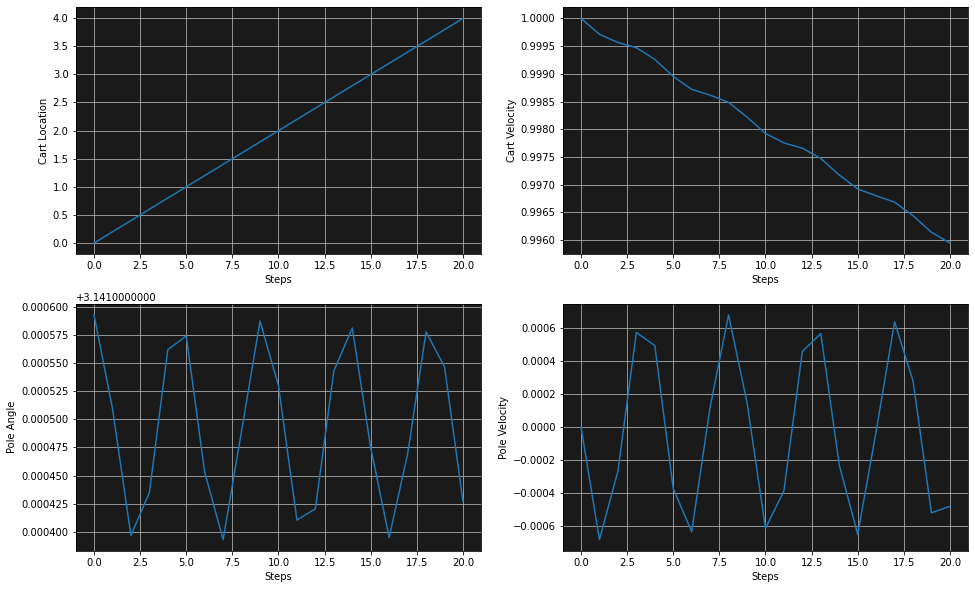

In [86]:
display_plots(simulate(steps=steps, initial_state=initial_state))

### Initial Velocity = 5

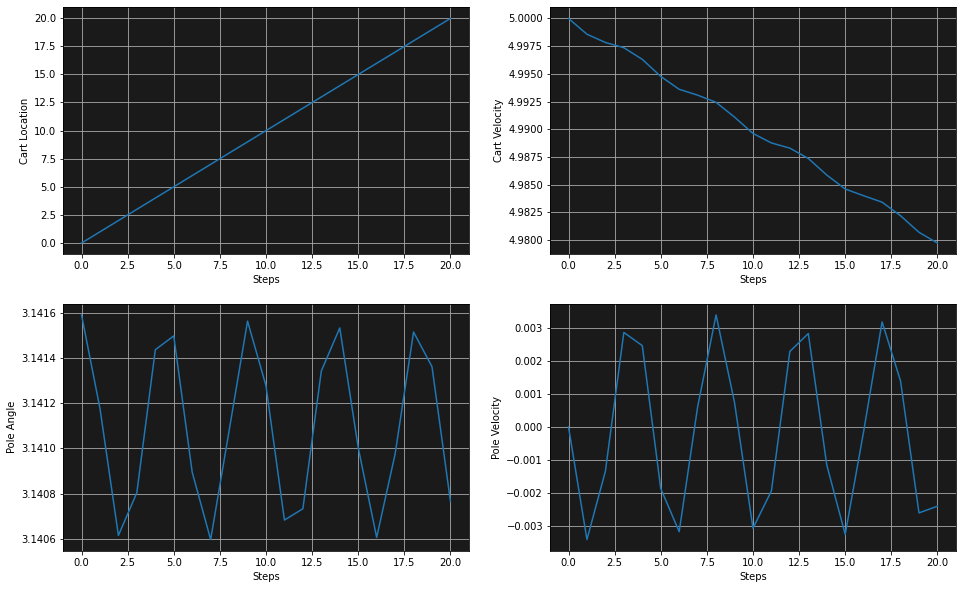

In [87]:
initial_state = [0, 5, np.pi, 0]
display_plots(simulate(steps=steps, initial_state=initial_state))

### Initial Velocity = 10

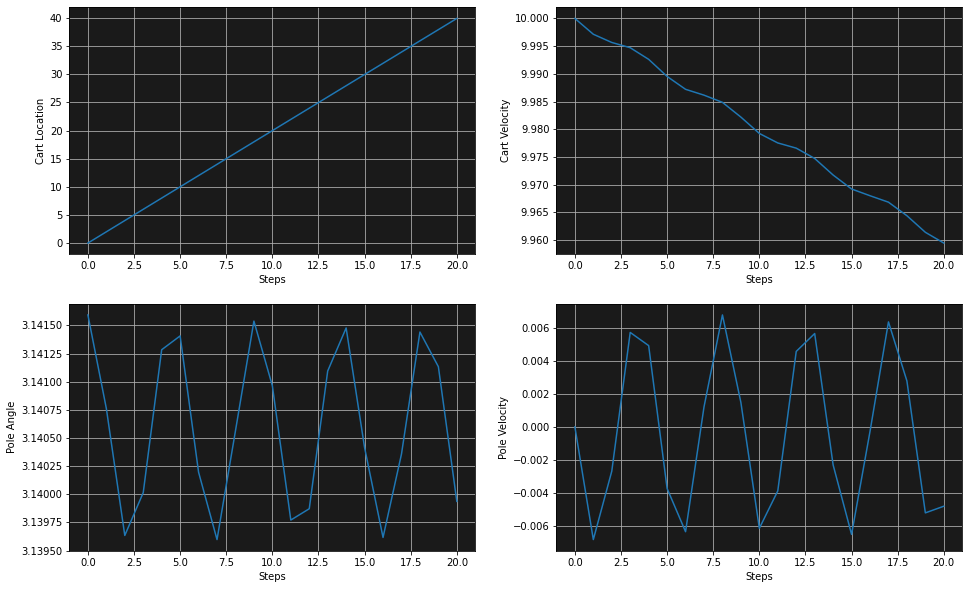

In [7]:
initial_state = [0, 10, np.pi, 0]
display_plots(simulate(steps=steps, initial_state=initial_state))

### Initial Velocity = -10

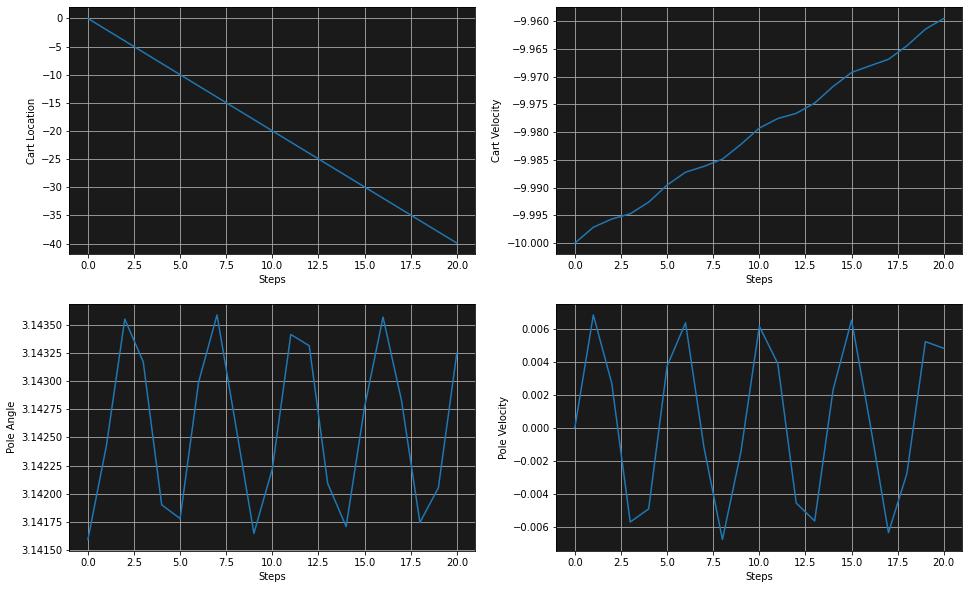

In [8]:
initial_state = [0, -10, np.pi, 0]
display_plots(simulate(steps=steps, initial_state=initial_state))

### Initial Pole Velocity = 5

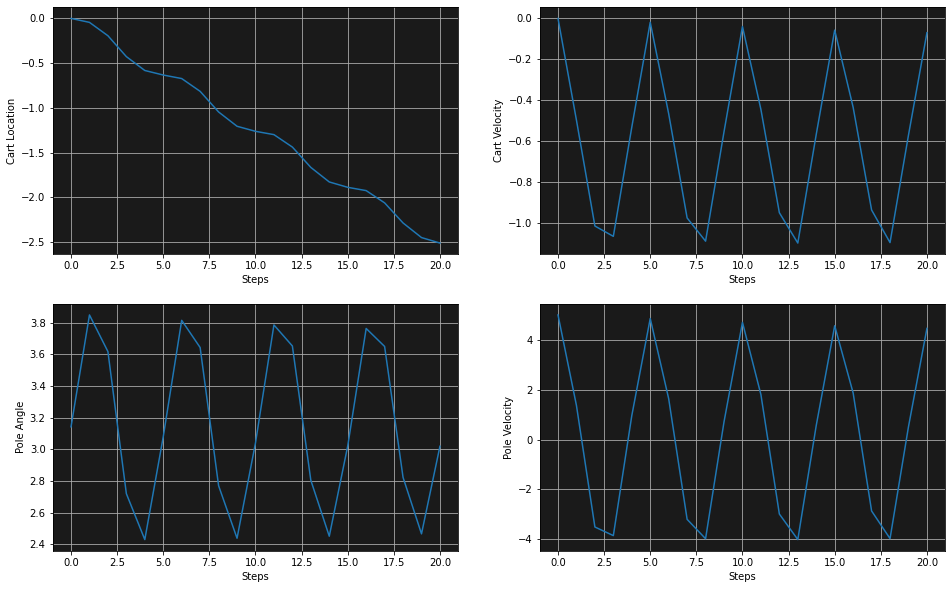

In [9]:
initial_state = [0, 0, np.pi, 5]
display_plots(simulate(steps=steps, initial_state=initial_state))

### Complete Rotation

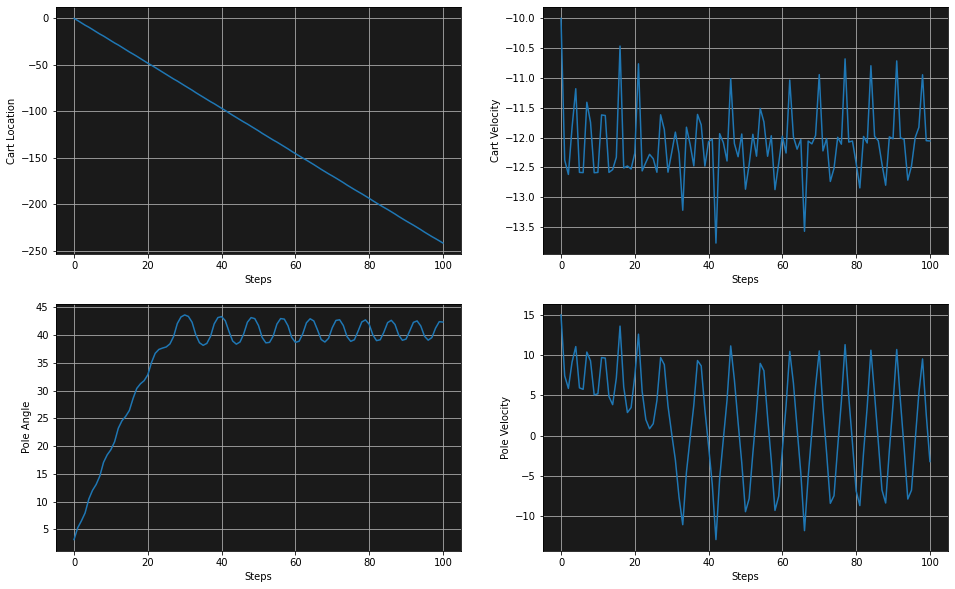

In [10]:
initial_state = [0, -10, np.pi, 15]
display_plots(simulate(steps=100, initial_state=initial_state))

### Changes of state

You know from 3F2 that a simple linear controller works for this system, as long as you know where the stationary point is, and have access to the equations of motion so that you can linearise them. But in general, we do not know the equations behind the evolution of a physical system, and so we will take a different approach. What do have are _observations_ of the time evolution of the system. So we will use the simulations like the ones you did above to gather data about the system, and develop a _model_ for this time evolution. 


We will want to build a _model_ for the time evolution of the system. The model is a function $f(X)$ that takes the current state of the system, and maps it onto a new state, which is its prediction for the state at a later time. Let the state of the system be described by a vector X, given by

$$
X = [x, \dot x, \theta, \dot \theta]
$$

Given the current state $X$, let us call $Y$ the state of the system after a single call to the `PerformAction` function (with 0.0 as the force argument, or no argument, which is equivalent). 

#### Task 1.2

To investigate and visualise the functional relationship between $X$ and $Y$, initialise the system using a random value for all state variables, and then scan through one of the state variables in a suitable range (don't forget to reset all the state variables after each call to `PerformAction`), and plot $Y$ as a function of your scan. 

You will observe that the relationship between $X$ and $Y$ as defined above is nearly linear, which is not surprising because the change in one step is small.

We can take account of this and model the _change_ in state vector, rather than taking the new state vector itself as the target of our model. So we define the new target for the modelling as $Y\equiv X(T)-X(0)$, where $X(t)$ represents the time evolution of the state under the dynamics, and T corresponds to a single call to `PerformAction`. Note that in principle we could model changes corresponding arbitrary time shifts, rather than a single call to `PerformAction`, but the longer the time shift, the more complex the model would have to be. 

Explore this new functional relationship again (i) using scans of single variables, and (ii) contour plots where you take slices of the data in two of the variables while you keep the other two variables fixed (the `tricontourf` function of `matplotlib` is very useful). One of the variables has no effect on the next step - which one? 

##### a) Y = X(1) = state of system after 1 step

In [11]:
def plot_y_1step(initial_state, ranges):
    """
    Vary the initial value of each variable one-by-one (i.e. keeping the other 3 constant, set by initial_state)
    One step of performAction for each variable value.
    Plot of Y for different initial values of each variable.
    Y is the system's state after one step of performAction.
    Four plots are produced.
    """
    fig, axs = plt.subplots(2, 2, figsize=(16, 10))
    for i in range(4):
        positions = []
        velocities = []
        angles = []
        pole_vels = []
        rng = ranges[i]
        for val in ranges[i]:
            initial_state_copy = initial_state.copy()
            initial_state_copy[i] = val
            y = simulate(initial_state=initial_state_copy)[1]
            positions.append(y[0])
            velocities.append(y[1])
            angles.append(y[2])
            pole_vels.append(y[3])

        bnum1 = int(format(i, '#04b')[2]) #Binary number 1st digit
        bnum2 = int(format(i, '#04b')[3]) #Binary number 2nd digit
        axs[bnum1, bnum2].plot(ranges[i], positions, label='Cart Location')
        axs[bnum1, bnum2].plot(ranges[i], velocities, label='Cart Velocity')
        axs[bnum1, bnum2].plot(ranges[i], angles, label='Pole Angle')
        axs[bnum1, bnum2].plot(ranges[i], pole_vels, label='Pole Velocity')
        axs[bnum1, bnum2].set_facecolor((0.1, 0.1, 0.1))
        axs[bnum1, bnum2].grid()
        axs[bnum1, bnum2].legend()
    axs[0, 0].set_xlabel('Initial Value of Cart Location')
    axs[0, 1].set_xlabel('Initial Value of Cart Velocity')
    axs[1, 0].set_xlabel('Initial Value of Pole Angle')
    axs[1, 1].set_xlabel('Initial Value of Pole Velocity')

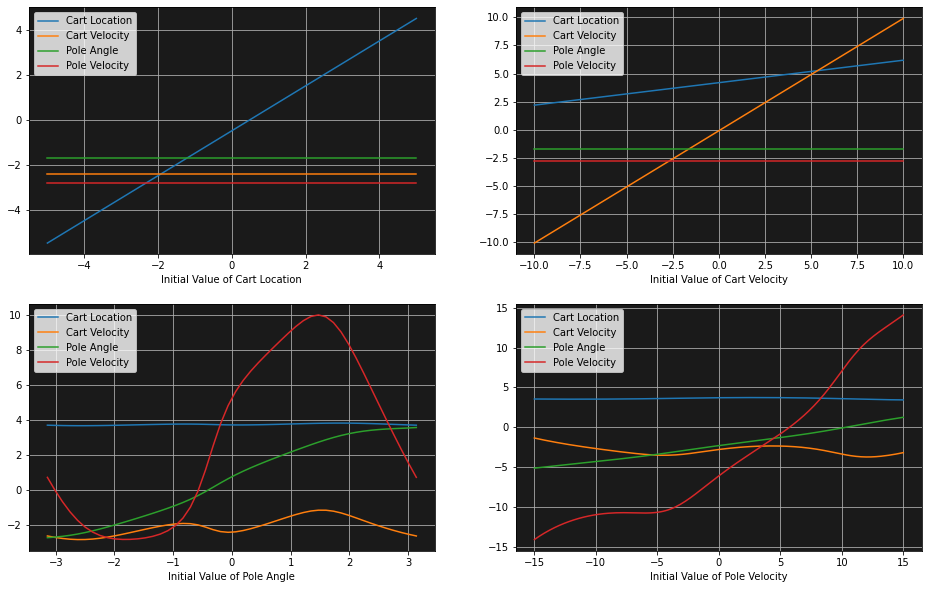

In [12]:
initial_state = [4.2, -2.3, -1.7, 3.1] #random initial state

ranges = [np.linspace(-5, 5, 50), #position range
np.linspace(-10, 10, 100), #velocity range
np.linspace(-np.pi, np.pi, 50), #angle range
np.linspace(-15, 15, 150)] #pole (angular) velocity range

plot_y_1step(initial_state, ranges)

##### b) Y = X(1) - X(0) = difference in states after 1 step
#####     i) Scans of single variables

In [44]:
def plot_y_diff(initial_state, ranges, model=None, figsize=(16,10)):
    """
    Vary the initial value of each variable one-by-one (i.e. keeping the other 3 constant, set by initial_state)
    One step of performAction for each variable value.
    Plot of Y for different initial values of each variable.
    Y is the difference between the system's state after one performAction and the initial state!!!
    Four plots are produced.
    """
    fig, axs = plt.subplots(2, 2, figsize=figsize)
    for i in range(4):
        positions = []
        velocities = []
        angles = []
        pole_vels = []
        if model:
            pred_pos = []
            pred_vel = []
            pred_ang = []
            pred_pol_vel = []
        for val in ranges[i]:
            initial_state_copy = initial_state.copy()
            initial_state_copy[i] = val
            y = simulate(initial_state=initial_state_copy)[1] - np.array(initial_state_copy)
            positions.append(y[0])
            velocities.append(y[1])
            angles.append(y[2])
            pole_vels.append(y[3])
            if model:
                y_pred = model.predict([initial_state_copy])[0]
                pred_pos.append(y_pred[0])
                pred_vel.append(y_pred[1])
                pred_ang.append(y_pred[2])
                pred_pol_vel.append(y_pred[3])

        bnum1 = int(format(i, '#04b')[2])
        bnum2 = int(format(i, '#04b')[3])
        axs[bnum1, bnum2].plot(ranges[i], positions, 'b-', label='Cart Location')
        axs[bnum1, bnum2].plot(ranges[i], velocities, 'g-', label='Cart Velocity')
        axs[bnum1, bnum2].plot(ranges[i], angles, 'r-', label='Pole Angle')
        axs[bnum1, bnum2].plot(ranges[i], pole_vels, 'y-', label='Pole Velocity')
        if model:
            axs[bnum1, bnum2].plot(ranges[i], pred_pos, 'b--', label='Predicted Cart Location')
            axs[bnum1, bnum2].plot(ranges[i], pred_vel, 'g--', label='Predicted Cart Velocity')
            axs[bnum1, bnum2].plot(ranges[i], pred_ang, 'r--', label='Predicted Pole Angle')
            axs[bnum1, bnum2].plot(ranges[i], pred_pol_vel, 'y--', label='Predicted Pole Velocity')
        axs[bnum1, bnum2].set_facecolor((0.1, 0.1, 0.1))
        axs[bnum1, bnum2].grid()
        axs[bnum1, bnum2].legend()
    axs[0, 0].set_xlabel('Initial Value of Cart Location')
    axs[0, 1].set_xlabel('Initial Value of Cart Velocity')
    axs[1, 0].set_xlabel('Initial Value of Pole Angle')
    axs[1, 1].set_xlabel('Initial Value of Pole Velocity')

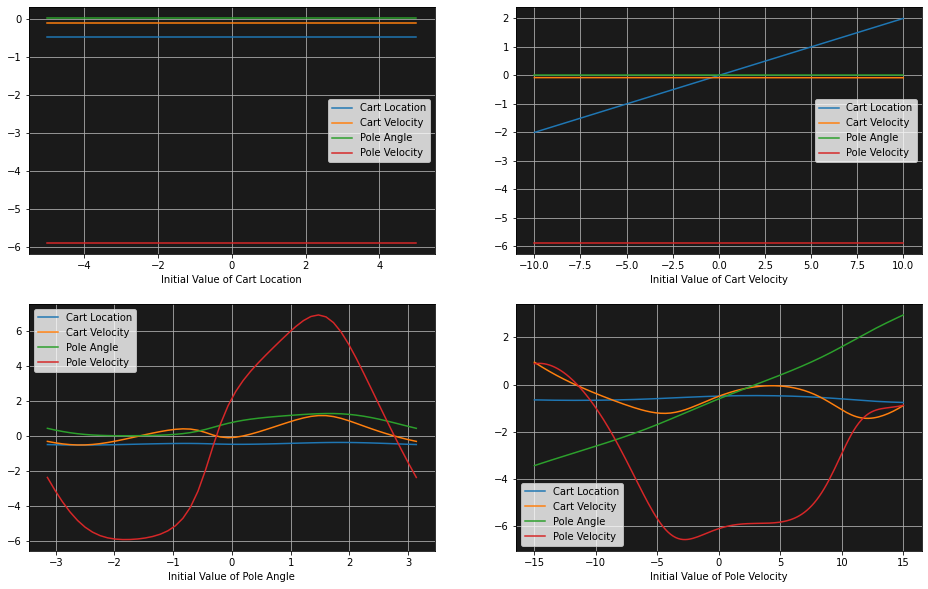

In [14]:
plot_y_diff(initial_state, ranges)

##### ii) Contour Plots

In [15]:
initial_state = [4.2, -2.3, -1.7, 3.1]

ranges = [np.linspace(-5, 5, 20), #position range
np.linspace(-10, 10, 40), #velocity range
np.linspace(-np.pi, np.pi, 20), #angle range
np.linspace(-15, 15, 60)] #pole (angular) velocity range
index_pairs = [[0, 1], [0, 2], [0, 3], [1, 2], [1, 3], [2, 3]]
labels = ['Initial Value of Cart Location', 'Initial Value of Cart Velocity', 
          'Initial Value of Pole Angle', 'Initial Value of Pole Velocity']

In [16]:
def plot_contours(initial_state, ranges):
    for index in index_pairs:
        fig, axs = plt.subplots(2, 2, figsize=(10, 10))
        i, j = index[0], index[1]
        x = y = np.zeros((len(ranges[i]), len(ranges[j]), 4))
        for k in range(len(ranges[i])):
            for l in range(len(ranges[j])):
                val1, val2 = ranges[i][k], ranges[j][l]
                initial_state_copy = initial_state.copy()
                initial_state_copy[i] = val1
                initial_state_copy[j] = val2
                x[k,l] = initial_state_copy
                state = simulate(initial_state=initial_state_copy)[1]
                y[k,l] = state - np.array(initial_state_copy)
        axs[0,0].contourf(ranges[j], ranges[i], y[:,:,0], cmap='plasma')
        axs[0,1].contourf(ranges[j], ranges[i], y[:,:,1], cmap='plasma')
        axs[1,0].contourf(ranges[j], ranges[i], y[:,:,2], cmap='plasma')
        axs[1,1].contourf(ranges[j], ranges[i], y[:,:,3], cmap='plasma')
        axs[0,0].set_title('Cart Location')
        axs[0,1].set_title('Cart Velocity')
        axs[1,0].set_title('Pole Angle')
        axs[1,1].set_title('Pole Velocity')
        for k in range(2):
            for l in range(2):
                axs[k,l].set_xlabel(labels[j])
                axs[k,l].set_ylabel(labels[i])

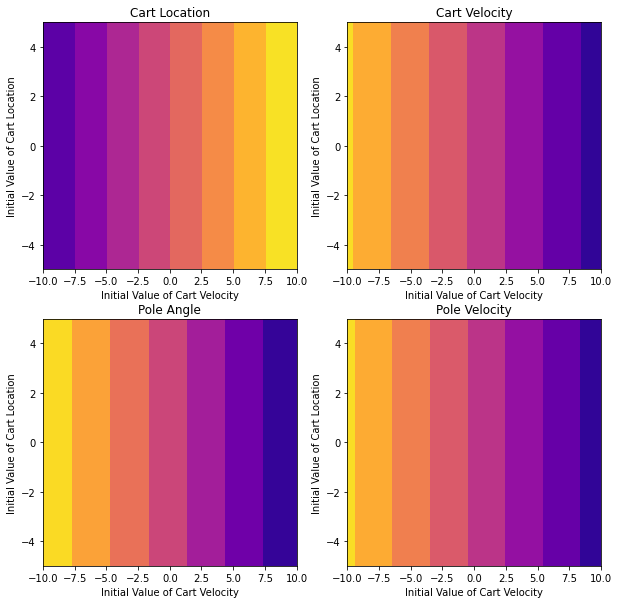

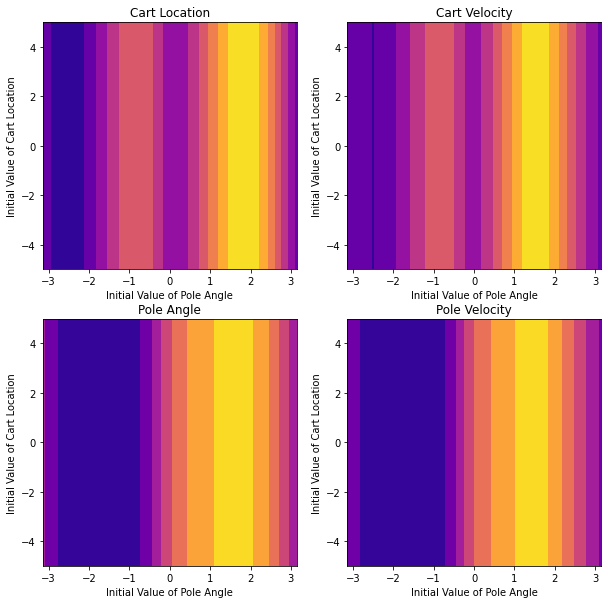

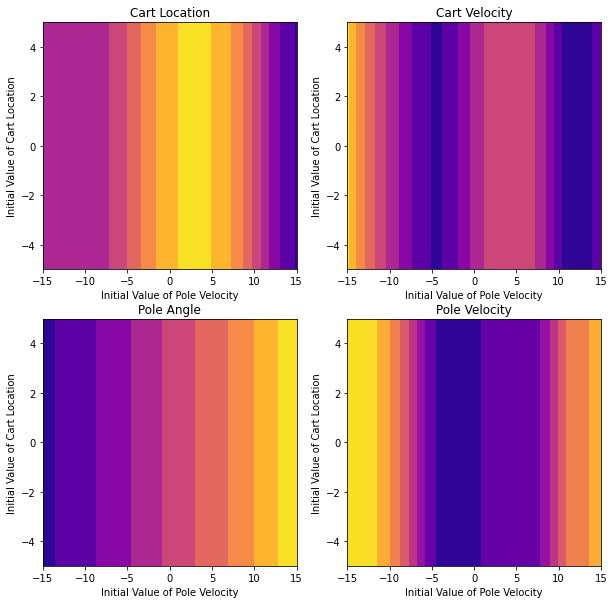

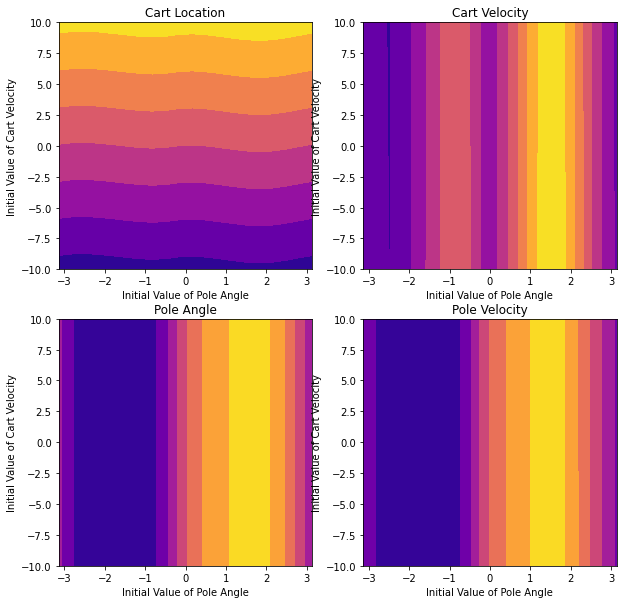

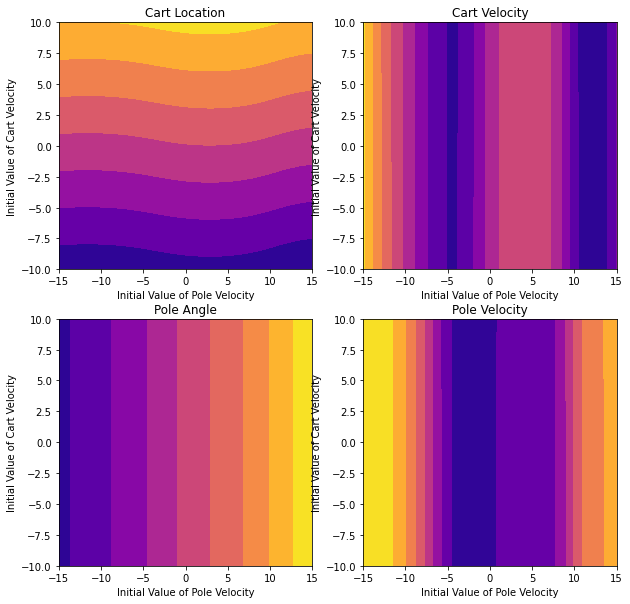

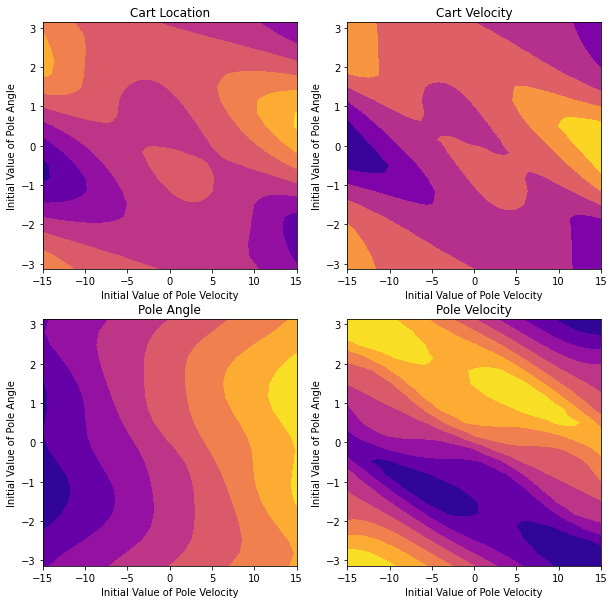

In [17]:
plot_contours(initial_state, ranges)

### Linear Model


The simplest model is a linear one, where the target $Y$ is assumed to be linear function of the current state $X$,
$$
f(X) = {\bf C} X
$$

where ${\bf C}$ is a $4\times 4$ matrix of coefficients. 

#### Task 1.3

By initialising the simulator in a completely random state (using suitable ranges) and running it for _one_ step, gather
data in the form of pairs of state vectors (X, Y), where X represents a state of the system at step $n$, so $X\equiv X(n)$
and Y represent the change in state after a single call to `performAction` (with zero force), so $Y\equiv X(n+1)-X(n)$. 
Start with 500 data points. 

In [18]:
def generate_data(n, train_prop=0.7, remap__angle=False):
    x_stack = []
    y_stack = []
    for i in range(n):
        initial_state = [np.random.normal(loc=0, scale=1.5), np.random.uniform(-10, 10),
                        np.random.uniform(-np.pi, np.pi), np.random.uniform(-15, 15)]
        x1 = simulate(initial_state=initial_state, remap__angle=remap__angle)[1]
        y = x1 - np.array(initial_state)
        x_stack.append(initial_state)
        y_stack.append(y)
    x_train, x_test = x_stack[:int(n*train_prop)], x_stack[int(n*train_prop):]
    y_train, y_test = y_stack[:int(n*train_prop)], y_stack[int(n*train_prop):]
    return x_train, y_train, x_test, y_test

In [103]:
n=500
x_train, y_train, x_test, y_test = generate_data(n, train_prop=0.8)

Using your data set, do linear regression to find the optimal coefficient matrix. Test your predictions against the data. One way to plot the results is to put the input state variable on the horizontal axis and on the vertical axis put the predicted state variable (i.e. what should be the "next step") and the real next step. Another way is to put the target data (i.e. the real "next step") on the horizontal axis and the predicted "next step" on the vertical axis. In this latter plot, a perfect prediction would correspond to a perfect straight line. You should also repeat the "scans" from the previous task, and plot simultaneously the real change in state with your predicted change in state as a function of your scan. Which variables are predicted well by the linear model and which ones are not? Why ? 

In [104]:
reg = linear_model.LinearRegression().fit(x_train, y_train)
preds = reg.predict(x_test)

In [105]:
x_testarr = np.array(x_test)
y_testarr = np.array(y_test)

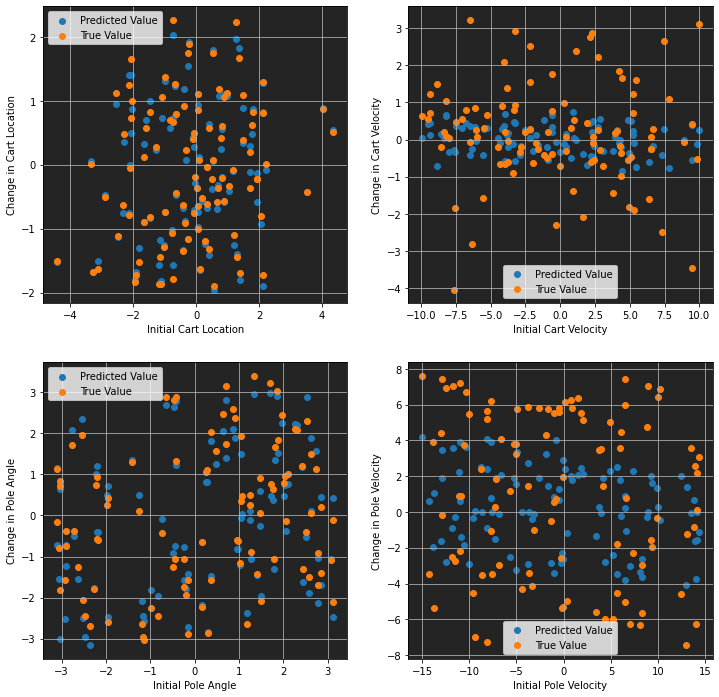

In [106]:
fig, axs = plt.subplots(2, 2, figsize=(12, 12))
axs[0,0].scatter(x_testarr[:,0], preds[:,0], label='Predicted Value')
axs[0,0].scatter(x_testarr[:,0], y_testarr[:,0], label='True Value')
axs[0,0].set_xlabel('Initial Cart Location')
axs[0,0].set_ylabel('Change in Cart Location')

axs[0,1].scatter(x_testarr[:,1], preds[:,1], label='Predicted Value')
axs[0,1].scatter(x_testarr[:,1], y_testarr[:,1], label='True Value')
axs[0,1].set_xlabel('Initial Cart Velocity')
axs[0,1].set_ylabel('Change in Cart Velocity')

axs[1,0].scatter(x_testarr[:,2], preds[:,2], label='Predicted Value')
axs[1,0].scatter(x_testarr[:,2], y_testarr[:,2], label='True Value')
axs[1,0].set_xlabel('Initial Pole Angle')
axs[1,0].set_ylabel('Change in Pole Angle')

axs[1,1].scatter(x_testarr[:,3], preds[:,3], label='Predicted Value')
axs[1,1].scatter(x_testarr[:,3], y_testarr[:,3], label='True Value')
axs[1,1].set_xlabel('Initial Pole Velocity')
axs[1,1].set_ylabel('Change in Pole Velocity')

for i in range(2):
    for j in range(2):
        axs[i,j].legend()
        axs[i,j].set_facecolor((0.14, 0.14, 0.14))
        axs[i,j].grid()

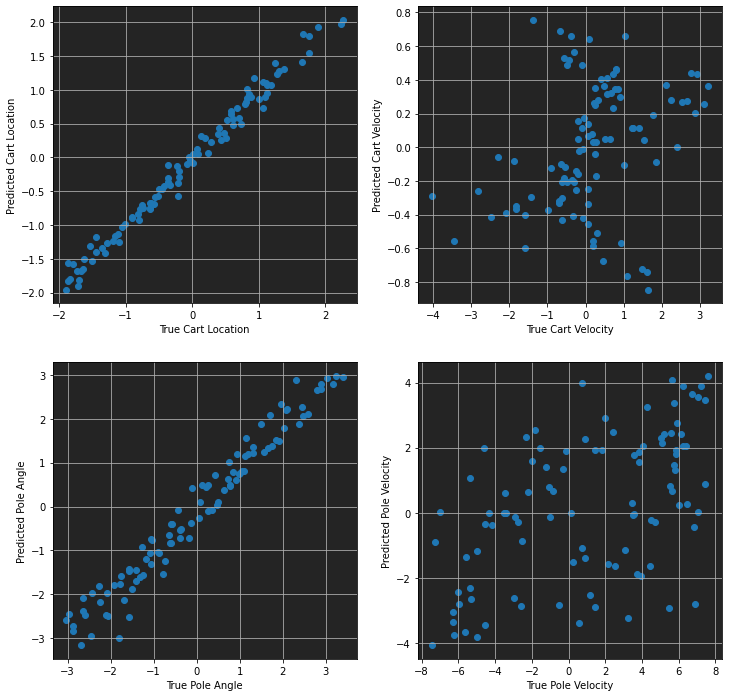

In [107]:
fig, axs = plt.subplots(2, 2, figsize=(12, 12))
axs[0,0].scatter(y_testarr[:,0], preds[:,0])
axs[0,0].set_xlabel('True Cart Location')
axs[0,0].set_ylabel('Predicted Cart Location')

axs[0,1].scatter(y_testarr[:,1], preds[:,1])
axs[0,1].set_xlabel('True Cart Velocity')
axs[0,1].set_ylabel('Predicted Cart Velocity')

axs[1,0].scatter(y_testarr[:,2], preds[:,2])
axs[1,0].set_xlabel('True Pole Angle')
axs[1,0].set_ylabel('Predicted Pole Angle')

axs[1,1].scatter(y_testarr[:,3], preds[:,3])
axs[1,1].set_xlabel('True Pole Velocity')
axs[1,1].set_ylabel('Predicted Pole Velocity')

for i in range(2):
    for j in range(2):
        axs[i,j].set_facecolor((0.14, 0.14, 0.14))
        axs[i,j].grid()

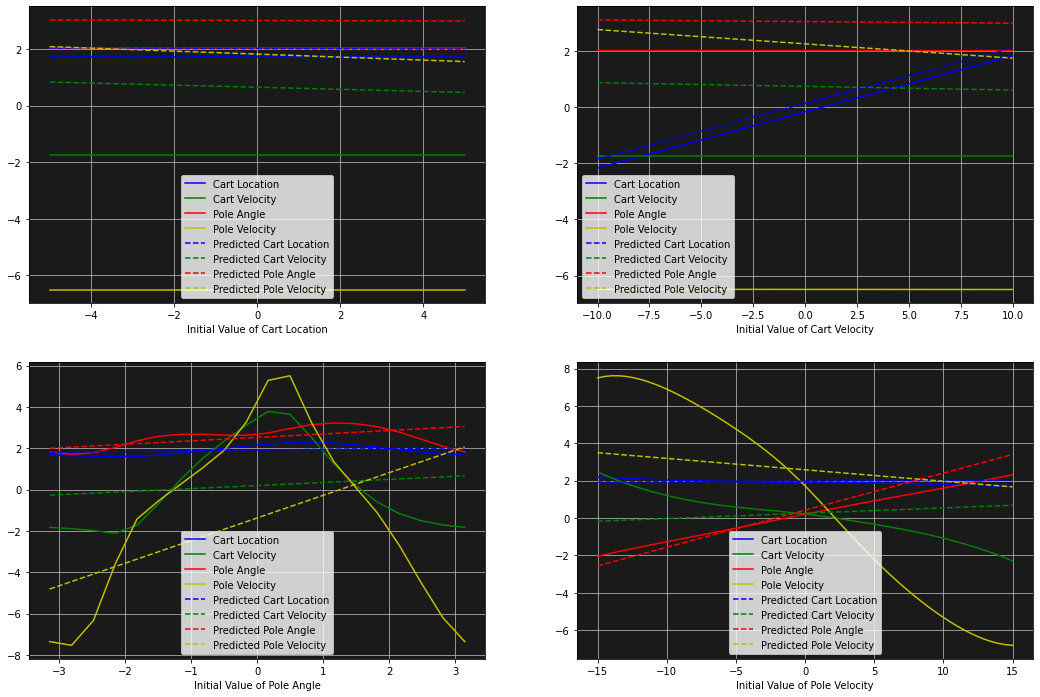

In [108]:
plot_y_diff(initial_state=initial_state, ranges=ranges, model=reg, figsize=(18,12))

#### Task 1.4

The true test of the model is not how it matches with the gathered data it was fit to, but whether it can predict the time evolution of the physical system. Iterate the model to predict the time evolution of the system, and compare using various initial conditions how accurate the predictions are with respect to the true dynamics started from the same initial conditions. (Note that the model is being used deterministically, with no noise added)

Since your models above predict the _change_ in the state variable, the iterated time evolution is
$$
X_{n+1} \leftarrow X_n + f(X_n)
$$

Plot the true time evolution of the system as well as that of your fitted models for many cycles, and for different initial conditions, including ones where the pole makes a full circle. 

_Angle range_ If you leave the angle without remapping, your solution with the iterated model will diverge. Why is that? Ensure that you remap the angle during the above iterations. (Note how remapping is not needed in the true dynamics, since that is nonlinear, and the angle only appears inside trigonometric functions that are periodic anyway).

In [109]:
def create_initialStates(n):
    initial_states = [[0, 0, np.pi, 0]]
    for i in range(n):
        initial_states.append([np.random.normal(loc=0, scale=1.5), np.random.uniform(-10, 10),
                            np.random.uniform(-np.pi, np.pi), np.random.uniform(-15, 15)])
    return initial_states

In [110]:
def plot_ModelVsTrue_OverTime(steps, initial_states, model):
    for i in range(len(initial_states)):
        initial_state = initial_states[i]
        pred_states, initial_state_copy = initial_state.copy(), initial_state.copy()
        true_states = simulate(initial_state=initial_state, steps=steps, remap__angle=True)
        for step in range(steps):
            initial_state_copy[2] = remap_angle(initial_state_copy[2])
            next_pred = model.predict([initial_state_copy])[0] + initial_state_copy
            next_pred[2] = remap_angle(next_pred[2])
            pred_states = np.vstack((pred_states, next_pred))
            initial_state_copy = next_pred
        display_plots(true_states, model=True, model_states=pred_states)

In [111]:
n=5
initial_states = create_initialStates(n)

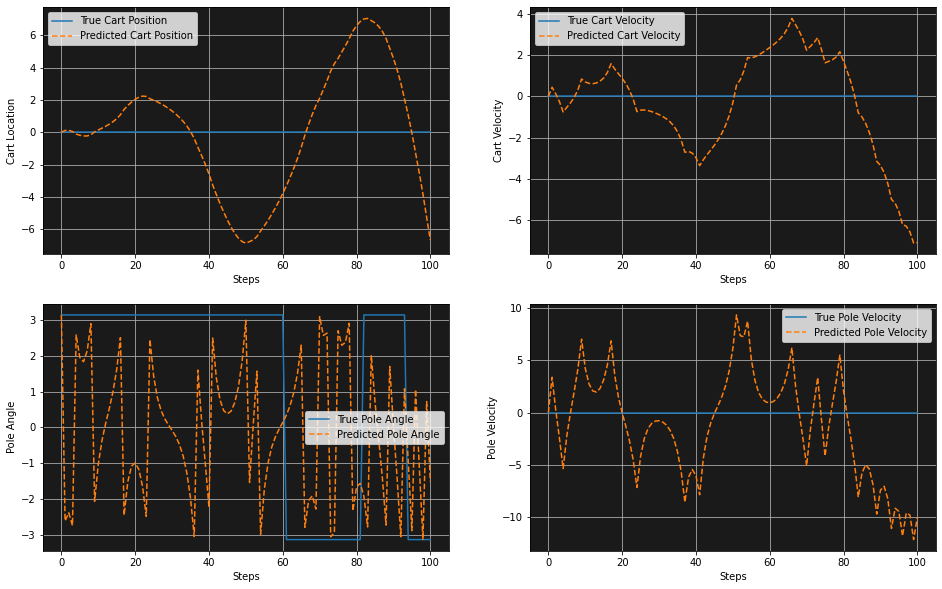

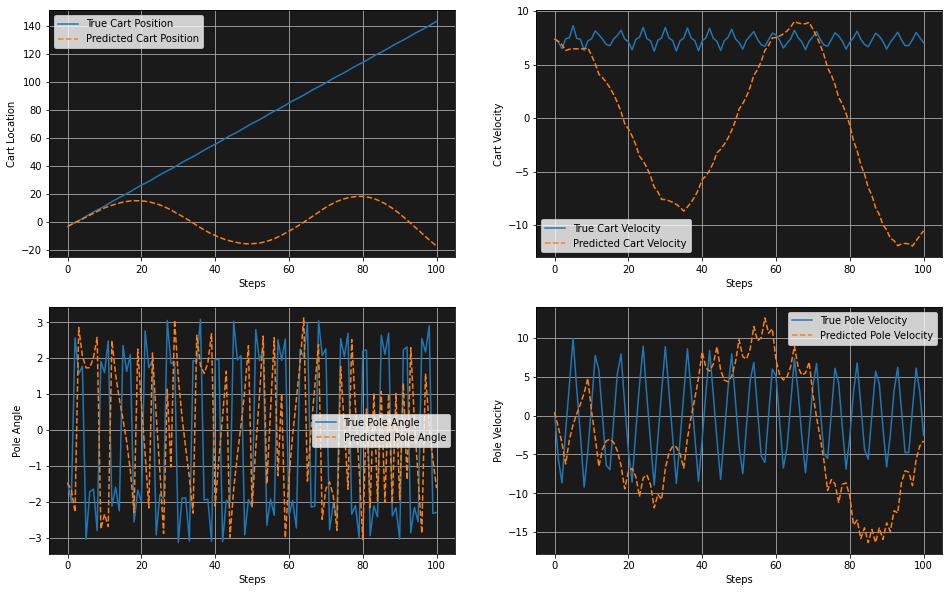

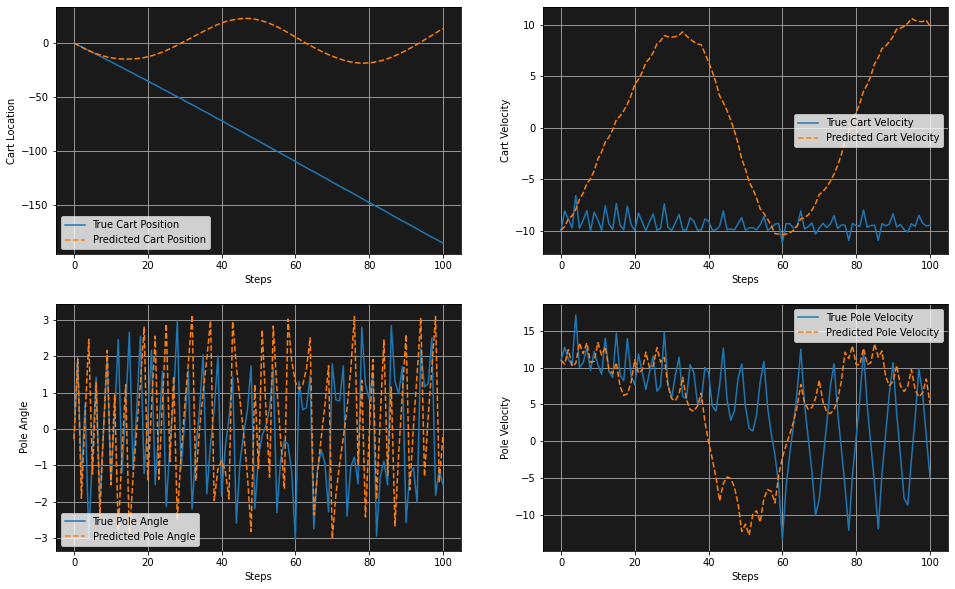

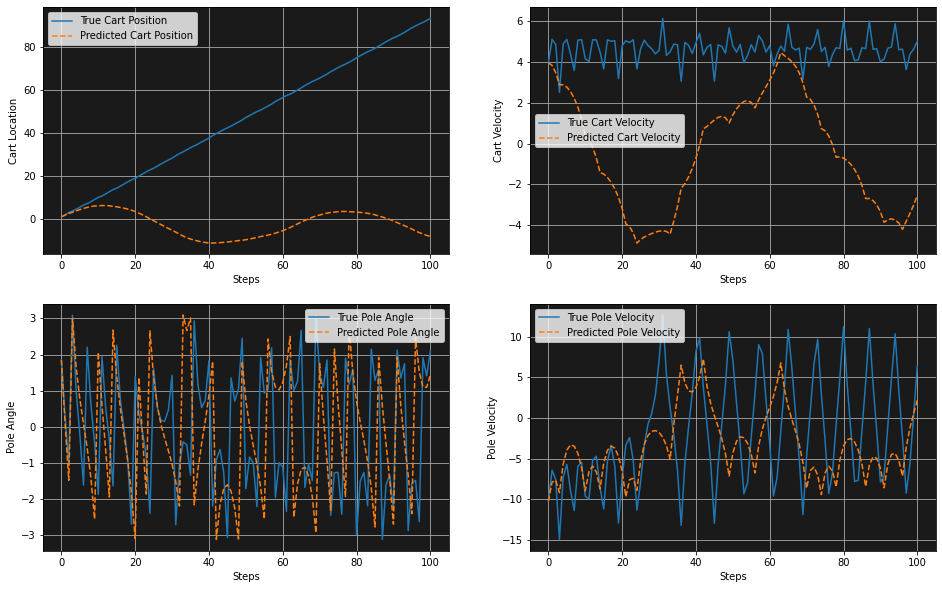

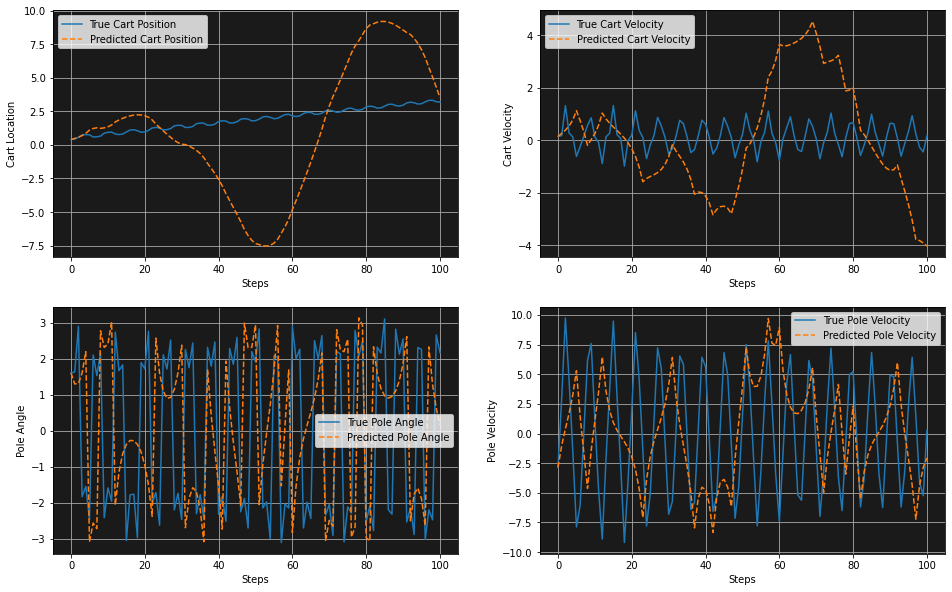

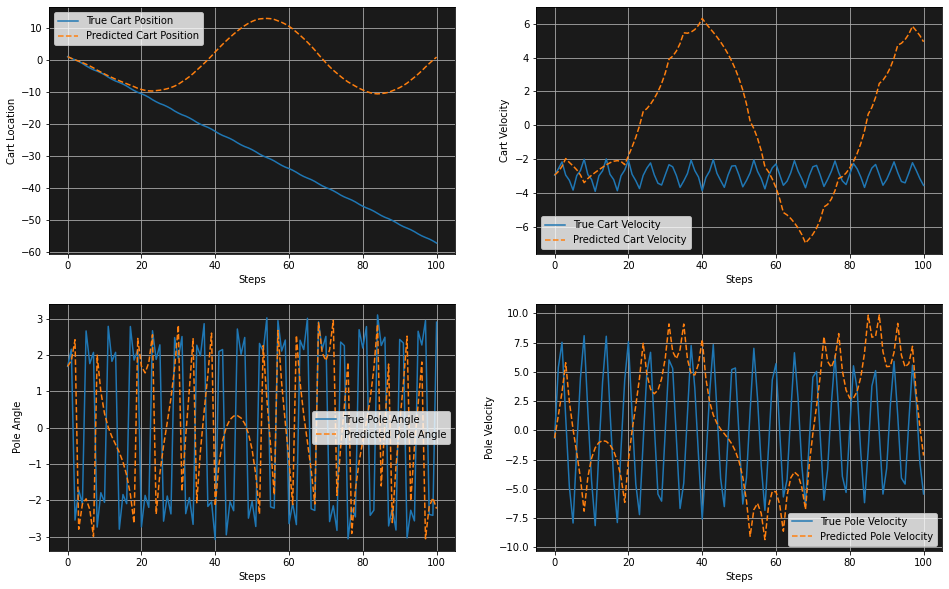

In [119]:
plot_ModelVsTrue_OverTime(100, initial_states, reg)

#### Remapped Angle Training Data

In [116]:
initial_states[1]

[-3.4038434885586937,
 7.37790377358014,
 -1.4758408407797177,
 0.38655072865056184]

In [113]:
n=500
x_train_r, y_train_r, x_test_r, y_test_r = generate_data(n, train_prop=0.8, remap__angle=True)

In [114]:
reg_r = linear_model.LinearRegression().fit(x_train_r, y_train_r)

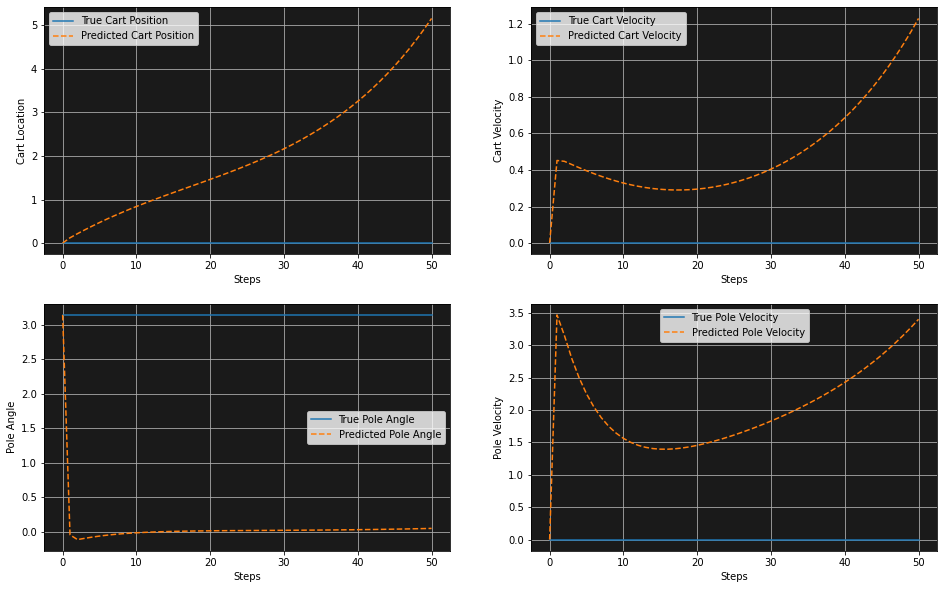

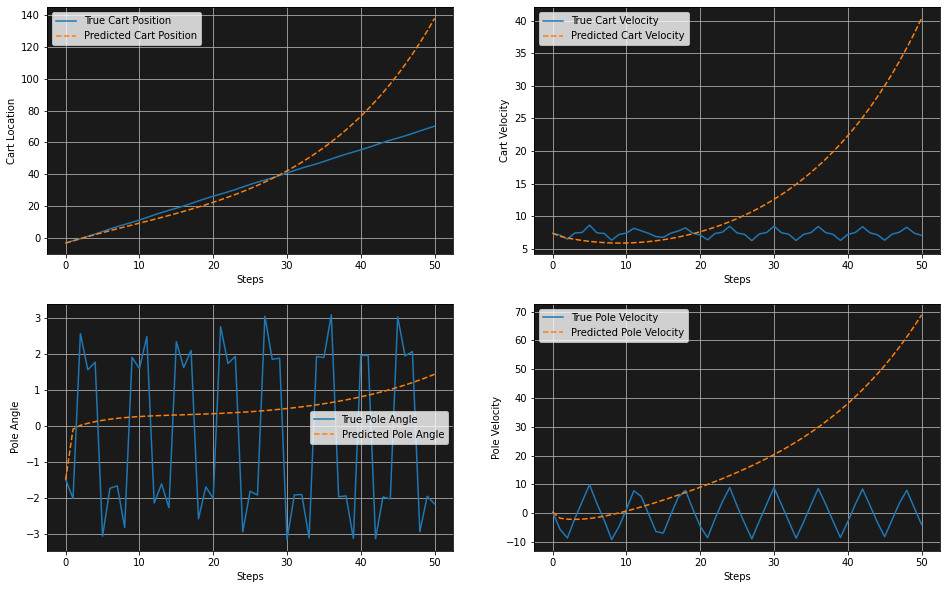

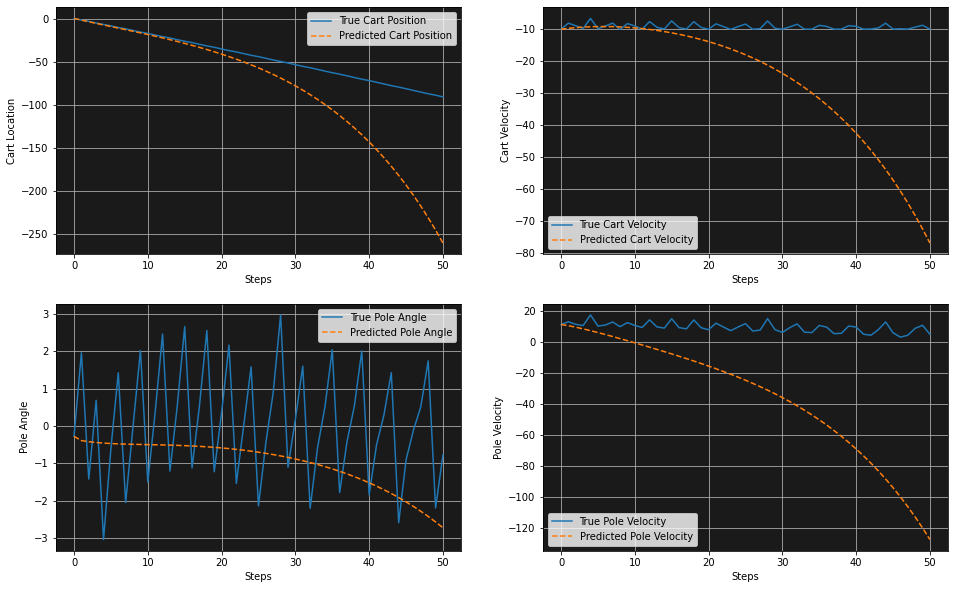

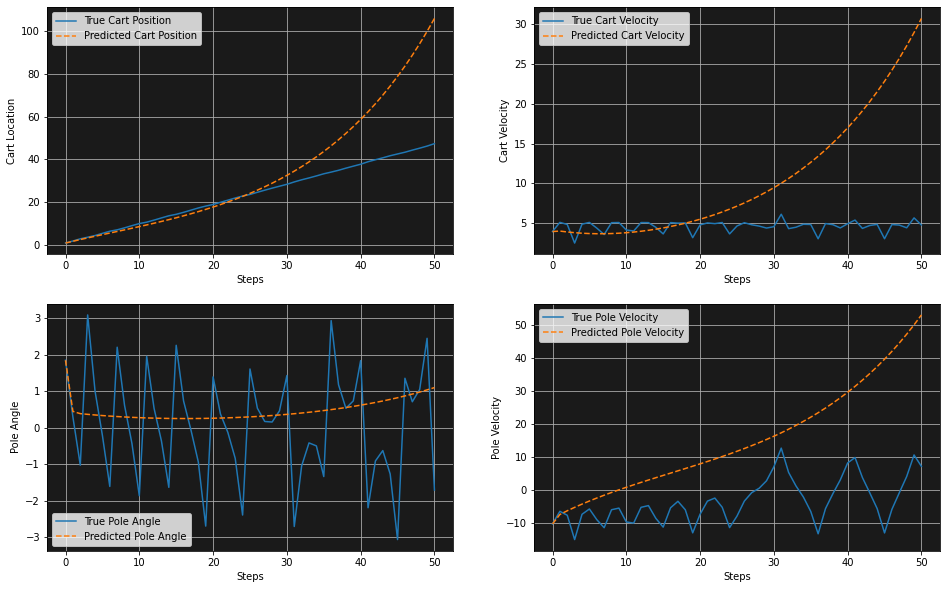

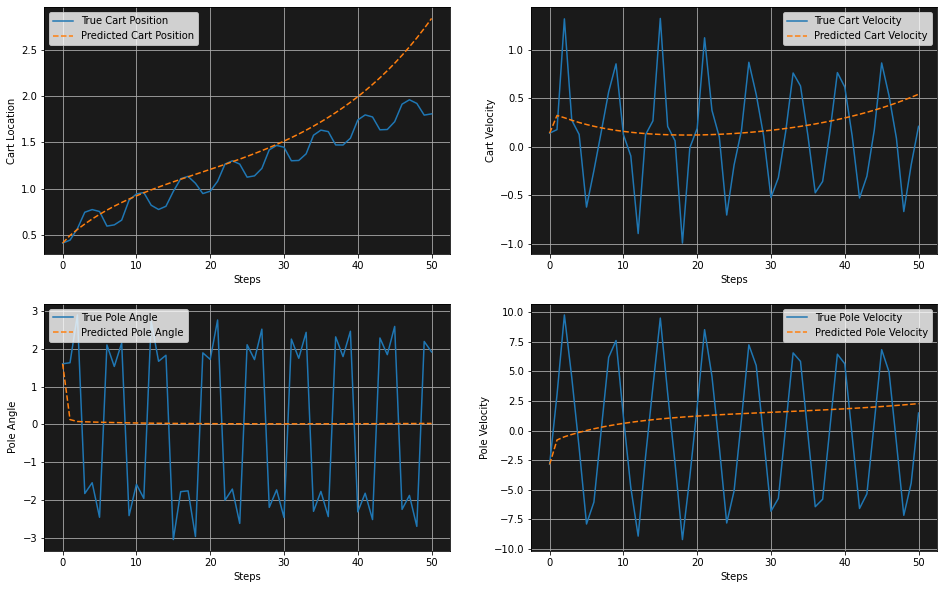

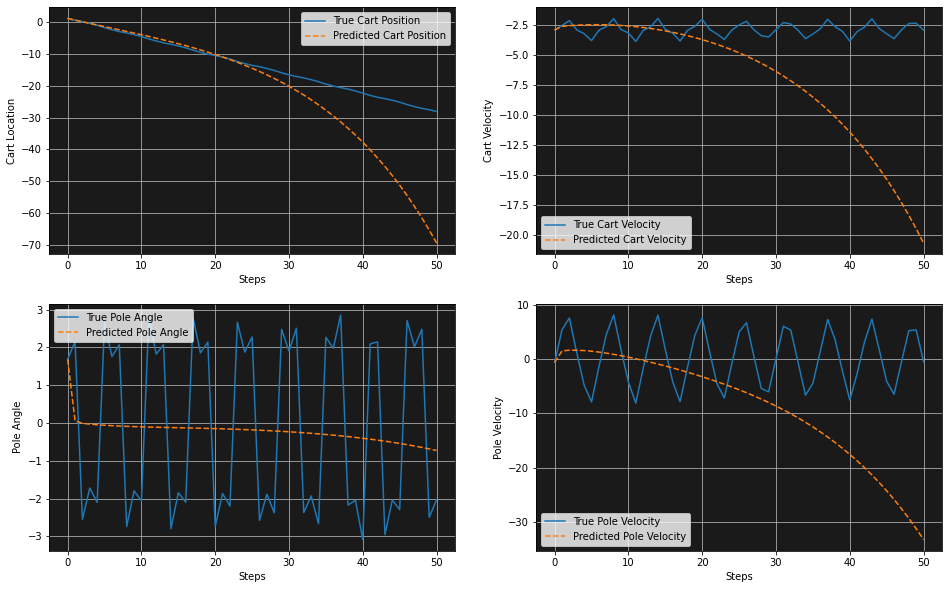

In [117]:
plot_ModelVsTrue_OverTime(50, initial_states, reg_r)

## Week 2

### Nonlinear model
As you observed above, the linear model is not particularly good. In order to do better, we need nonlinear modelling. Next you are going to do build a nonlinear model using a linear regression with nonlinear basis functions. Given a data set of (X,Y) pairs, the model function is given by

$$
f(X) = \sum_i \alpha_i K(X, X_i)
$$

where the sum runs over the basis functions, $\alpha_i$ are the corresponding coefficients, and $K$ is a _kernel function_ that is used to define the nonlinear basis. The kernel function takes two arguments, the first one $X$ is the state vector where you evaluate the basis function, and the second argument, $X_i$ is another state vector which we use to place the basis function somewhere in the state space. To make the basis functions relevant, we take the set of locations $\{X_i\}$ to be a subset of the gathered data points.  

If you place a basis functions on every location at which you have data, the functional form above is equivalent to 
the mean of a _Gaussian process_ with covariance given by the kernel _K_. This view of the regression problem is particularly helpful 
if the data is stochastic, i.e. it has some noise component which we can model. 

For the present problem, let us use a Gaussian kernel function,

$$
K(X,X') = e^{-\sum_j \frac{\left(X^{(j)}-X'^{(j)}\right)^2}{2\sigma_j^2}}
$$

Here $X^{(j)}$ refers to the $j$th component of the state vector. There is one caveat for using this kernel function in our
current situation: one of our state vector components, $\theta$ is periodic. It helps quite a bit if we introduce this
periodicity in our kernel function, and we can do that by using $\sin^2\left( (\theta - \theta')/2 \right)$ in place
of $\left(\theta -\theta' \right)^2$ in the part of the kernel function that corresponds to the angle variable. The parameters
$\sigma_j$ are _length scale_ hyperparameters of the model, and need to be known, guessed or fitted. 



If we have $N$ data locations (each is an (X,Y) pair but remember that here X is a vector and Y is a scalar), substituting this data into
the model functional form yields the following linear system

$$
K_{NN} \alpha_N = Y_N
$$

where the subscript $N$ was used to emphasize the size of the array rather than an index. The unknown coefficients are collected
into the vector $\alpha_N$, the elements of the matrix are given by the kernel function, 

$$
[K_{NN}]_{i,i'} = K(X_i,X_{i'})
$$

and $Y_N$ is a vector of the target function values. With Gaussian basis functions, the condition number of the matrix is enormous, and a direct solution of the above linear system would be
rather unstable. One way to get around this is to _regularise_ the linear system. Tikhonov regularisation is to modify it to 

$$
(K_{NN} + \lambda I) \alpha_N = Y_N
$$
with solution
$$
\alpha_N = [K_{NN} + \lambda I]^{-1} Y_N
$$

where $\lambda$ is a parameter. The smaller the values of $\lambda$, the closer is the fit to the data, but the more unstable
the linear system. Interestingly, this is also exactly the form of the (mean) solution in the Gaussian process regression problem of
inference in the presence of noisy input data, with the identification that $\lambda$ is the variance of the data noise. 

Suppose we collected $N$ pairs of $(X,Y)$ data pairs, and we choose a subset $M$ of the $X$ locations to serve as basis function centres.
The linear system is then not square:
$$
K_{NM} \alpha_M = Y_N
$$
where again the subscripts indicate dimensions, $K_{MN}$ is an $M \times N$ matrix with elements corresponding to the $M$ basis locations
and all the $N$ data point locations. We have fewer unknown coefficients than data points, so the problem is over-determined. 
The least squares solution would be
$$
\alpha_M = [K_{MN} K_{NM}]^{-1} K_{MN} Y_N
$$
i.e. using the pseudoinverse rather than the inverse. The matrix in square brackets will in general be uninvertible or very badly 
conditioned, so again we need to regularise. Interestingly, rather just adding a multiple of the identity matrix like in the
square case, we can look to Gaussian process inference for a better idea. It turns out that a _sparse Gaussian process_ precisely
corresponds to this case. There, the model is written as a conditional probability not on the original $N$ data values directly, but on the
unknown function values at the $M$ data locations that are chosen for the basis function centers. The vector of linear coefficients of
the fitted model are then given by 

$$
\alpha^{(j)}_M = \left(K_{MN}K_{NM} + \lambda K_{MM} \right)^{-1} K_{MN}  Y_N^{(j)}
$$

where $K_{MM}$ is an $M \times M$ matrix with elements that are given by the kernel function evaluated between the locations
selected as basis locations. The interpretation of this is that the least squares system is Tikhonov regularised but the regulariser
is evaluated in the kernel-norm, rather than the Euclidean norm. 


To apply all the above to the cartpole system, we have to create four separate models for the four components of
the state vector, these are indexed by $j$. In the absence of data noise to guide the selection of $\lambda$, you need to experiment
with different values (e.g. between 1E-6 and 1E-1, on a log scale). You will also need to select the length scale parameters $\sigma_j$ for each state variable. A good start is the standard deviation
of the state variable in your dataset. Note that in the Gaussian process inference view of this problem, these hyperparameters 
would be optimised by minimising the log-likelihood, feel free to research this and experiment with it if you have time. 

**Note: You should never use the `np.linalg.inv` function to invert the matrix when solving a linear system, because that can be
numerically unstable for such ill-conditioned matrices, but instead use `np.linalg.lstsq`, which solves equations of the
form $Ax=b$ directly in a least-squares sense.**

#### Task 2.1

Fit a model of the system using the data you gathered earlier. Your target function could be either again the change in
state after one step as before, or the _error of your linear model_ in the change in state. Verify using scatterplots that
the nonlinear model indeed fits the data. Study the convergence of the model (i.e. the systematic reduction in error) as a
function of increasing data amount, and the increasing number of basis functions (e.g. start with $M=10$ and increase by
factors of 2, select the data locations for the basis randomly from the data). Also plot 2D slices of your target function
and the fit, as well as do roll-outs to see how closely the iterated model matches the real dynamics for a wide range of
sensible initial conditions. How long does your model show reasonable agreement with the real dynamics? Quantify this in units of time
and also in the number of oscillation cycles. How does this correlate with the pointwise accuracy you measure on random test data? 

An alternative to random data locations is to use _quasirandom sequences_, these provide a set of locations in an arbitrary dimensional unit cube that are "nicely" spaced out for sampling, better than random draws. You can use the `sobol_seq` module to generate such locations (read the on-line example, but each new location is obtained with a call to the `vec, seed = sobol_seq.i4_sobol(4, seed)` function for 4 dimensions, with the seed provided by the previous call)

## Control

Having developed a good model for the dynamics, now it is time to control the system. In this exercise we will create a controller
to achieve a desired state by parametrising the actions of the controller, and optimising those parameters through evaluation of
the performance. This is called _reinforcement learning_ in general. Using the interaction of the controller with the system
to improve it is "direct policy search". There are many other, more sophisticated strategies.  

When you call the `performAction` routine, it takes a signed scalar which is interpreted as an external force on the cart. The value is passed through the `tanh` function 
before being interpreted as a force, this prevents the application of excessively large forces (the transformation is controlled
by the `max_force` variable inside the `CartPole` class.) The first thing you will need do is to modify your models (both the linear and nonlinear) to take account of this new state 
variable (i.e. your system now has 5 inputs, including the force F, and 4 outputs after a call to `performAction`). 

#### Task 2.2
Change your code so that the state vector now includes the action taken. Collect new data, again using random initial conditions or quasi-random sequences and one step, but this time include the action. Verify using scatter-plots, 1D and 2D scans and roll-outs that your models can predict the change in the state variables.  

### Policies

A _policy_ is a function $p(X)$ that defines what the action should be given the other state variables. The  goal is 
to find a policy function that when enacted, gives rise to the desired behaviour, in this case the pole being balanced around 
its unstable equilibrium position. 

### Objective

In order to optimize a policy, we need to define, mathematically, what we want to achieve. That is captured in an _objective function_ (also called
_loss function_), a measure of how close we are to the desired behaviour. In the present case, we want the pole to be upright,
so we could use the _loss function_

$$
l(X) = -\cos\theta
$$

But it is better, and more general, to define a _target state_, $X_0$, which we want the system to achieve, and use a loss
function that increases when the distance of the state from the target is larger. The following loss function achieves this, 

$$
l(X) = 1- e^{-|X-X_0|^2/2\sigma_l^2}
$$
where $\sigma_l$ is a scaling factor (you could introduce a separate one for each component of the state variable). The target
state for the cartpole system is $X_0 = [0,0,0,0]$. The advantage
of this form is that for large departures from the target, the loss is independent of the state. This expresses the notion
that if the pole is far away from being upright and stationary, we do not much care what it is doing. The above loss functions
are for a given state. We wish to keep the pole upright continuously, so the total loss of a trajectory should be a time
integral (sum, in practice) of the pointwise loss of the state over some interval,

$$
L = \sum_{i=1}^N l(X_i)
$$

The `CartPole` class contains a function to evaluate the above pointwise loss $l(X)$. 

### Linear control

We start with defining a linear policy, 

$$
p(X) = \bf{p} \cdot X
$$

with unknown coefficent vector ${\bf p}$. 

#### Task 2.3

Write code to evaluate the loss function for the trajectory of a rollout - use a short time horizon, but enough to capture 1-2 
oscillation periods. Before any optimisation, _visualise_ the loss function as you vary some parameters in ${\bf p}$, using 
similar 1D and 2D scans that you did for Task 1, i.e. varying just one or two elements of  ${\bf p}$ and plotting the loss 
as a function of those elements. 

Optimise the unknowns in the policy to minimise the loss function. Since you do not have too many variables, you can do this 
by looking at how the loss changes for small changes in policy variables. Feel free to use off-she-shelf optimizers, e.g. from 
the `scipy.optimize` package. For low dimensional optimization problems without gradients available, you can use the `Nelder-Mead` method. 

Do not expect the loss to be a simple function of the policy parameters, or to have only a few minima - it is likely that you need
to explore a variety of initial conditions. But there is not just one solution! Explore the loss as a function of the
elements of ${\bf p}$.  Find elements of ${\bf p}$ that are able to stabilize the pole when started just slightly displaced 
from the upright unstable position.

How close do you have to start? Plot the time evolution of the variables under the policy to demonstrate that the pole is kept upright. 

#### Task 2.4

In the previous task you used the real dynamics to evaluate a policy. But we have a good _model_ of the dynamics (the nonlinear
one from Task 2.1). Try to optimise the policy parameters by testing them on model-rollouts. 
You need to limit the time horizon (number of steps) to where you think your model is still 
accurate. (Using models to optimise policy is called _model predictive control_)



## Week 3: Sensitivity and stability

We go back to the beginning of the project, and modify the problem, introducing noise in various forms, and observe its effect. 

#### Task 3.1

Introduce noise in the _observed_ dynamics (but not in the real dynamics of the system). Refit the models (linear and nonlinear), 
and characterise the degradation in the prediction accuracy. Reoptimise the linear policy, and check its stability, contrasting it with the noise-free case.

#### Task 3.2

Introduce noise in the actual dynamics of the cartpole system, and repeat the tests of the previous task. 


## Week 4: Nonlinear control


#### Task 4.1

Define a _nonlinear_ policy, using a similar construction that we used for modelling the system, but this time we are modelling 
the `force` action as a function of the system state variables (i.e. the policy). The policy function is thus

$$
p(X) = \sum_i w_i e^{-0.5 (X-X_i)^T W (X-X_i)}
$$

where the locations $X_i$, the weights $w_i$ and the elements of the $4 \times 4$ symmetrix matrix $W$ are free parameters to be optimised (how do you make sure W is symmetric?). 
Use between 5-20  basis functions. Optimise the parameters, and try to obtain a policy that can keep the pole upright starting 
from the stable equilibrium (down) position. Feel free to use special initial conditions that seem reasonable. I suggest you experiment with the noise-free version of the problem.

_Note that this task is **hard**, and you may not achieve good control. Do not invest an inordinate amount of effort, but
move onto writing your final report if you do not succeed. You do not necessarily need to have found a good nonlinear controller to 
achieve a good grade in this project_, but I will be looking for good effort and evidence that you tried a variety of ideas. 

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=3c034b00-b2ba-4597-9d55-827f36054ef6' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>